In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Reshape, multiply
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework import ops
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

import keras.backend as K
from keras import optimizers
import random
import sys
import cv2
import os
from skimage import io
import tensorflow as tf
import numpy as np
from keras.models import load_model
from keras import initializers
from keras.callbacks import ModelCheckpoint, EarlyStopping

import csv
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Number of images in train set :  2993
Number of images in test set :  643
Number of images in val set :  642


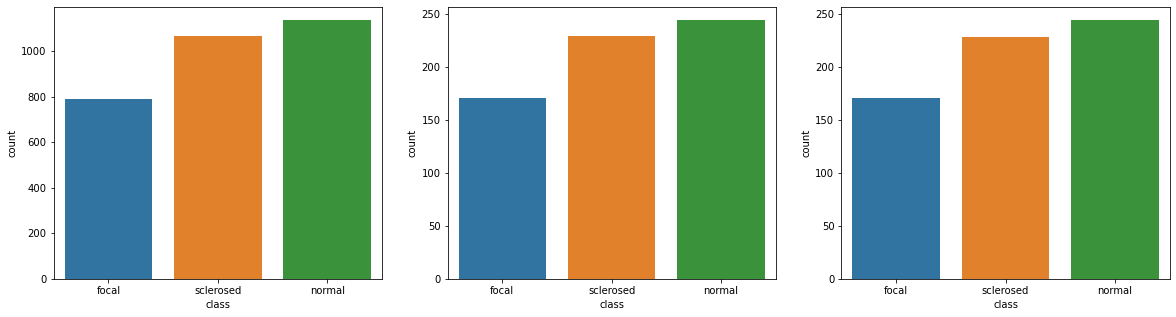

In [2]:
root_path = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/train/' #one more seg_train folder within
test_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/test/'
val_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/val/'
quantity_tr = {} 
quantity_te = {}
quantity_va = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))

for folder in os.listdir(val_folders):
    quantity_va[folder] = len(os.listdir(val_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_va.items()), index=range(0,len(quantity_va)), columns=['class','count'])

figure, ax = plt.subplots(1,3,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])
sns.barplot(x='class',y='count',data=quantity_val,ax=ax[2])
#sns.barplot(x='class',y='count',data=quantity_new_data,ax=ax[3])

print("Number of images in train set : ", sum(quantity_tr.values()))
print("Number of images in test set : ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in val set : ",sum(quantity_va.values()))
#print("Number of images in new dataset : ",sum(quantity_ne.values()))

plt.show()

In [3]:
category_num=3
BUFFER_SIZE = len(train_folders)
IMG_SIZE = 256

In [4]:
train_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)
validation_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)
test_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)

In [5]:
def train(BATCH_SIZE):
    train_generator = train_datagen.flow_from_directory(train_folders,
                                                        shuffle=BUFFER_SIZE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        target_size=(IMG_SIZE, IMG_SIZE))
    return train_generator

In [6]:
def validation(BATCH_SIZE):
    
    validation_generator = validation_datagen.flow_from_directory(val_folders, 
                                                                  shuffle=BUFFER_SIZE,
                                                                  batch_size=BATCH_SIZE, 
                                                                  class_mode='categorical', 
                                                                  target_size=(IMG_SIZE, IMG_SIZE))
    return validation_generator

In [7]:
def test(BATCH_SIZE):
    test_generator = test_datagen.flow_from_directory(test_folders,
                                                      shuffle=BUFFER_SIZE,
                                                      batch_size=BATCH_SIZE, 
                                                      class_mode='categorical',
                                                      target_size=(IMG_SIZE, IMG_SIZE))
    return test_generator

In [8]:
def show_few_images(number_of_examples, predict_using_model):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            path = os.path.join(train_folders,folder,image_ids[j])
            display = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
            display = display/IMG_SIZE
            
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(predict_using_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

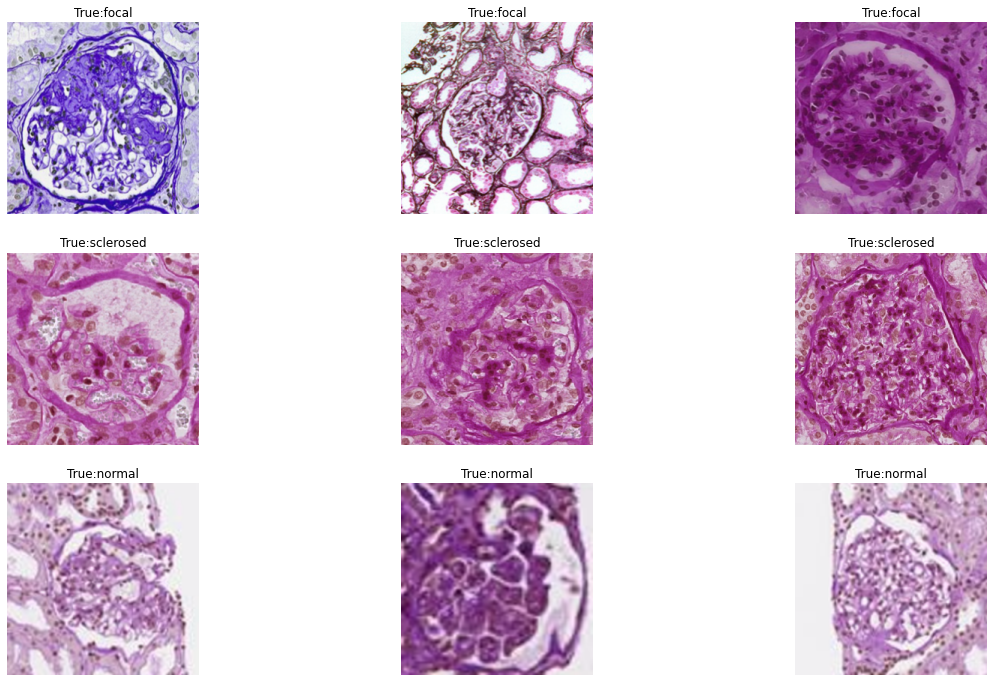

In [9]:
show_few_images(3,None)

In [10]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [11]:
with strategy.scope():
    model = tf.keras.applications.VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in model.layers:
                layers.trainable=False
    last_output = model.layers[-1].output
    output = Flatten()(last_output)
    output = Dense(128, activation = 'relu')(output)
    output = Dense(3, activation = 'softmax')(output)
    model = Model(model.input, output)
    model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [12]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(1)
data_validation = validation(1)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(1)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:local

[0.19171307981014252, 0.9471228718757629]

In [13]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(2)
data_validation = validation(2)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(2)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
1497/1497 [==============================] - 61s 32ms/step - loss: 0.0744 - acc: 0.9703 - val_loss: 0.2320 - val_acc: 0.9330
Epoch 2/30
1497/1497 [==============================] - 48s 32ms/step - loss: 0.0705 - acc: 0.9716 - val_loss: 0.2136 - val_acc: 0.9470
Epoch 3/30
1497/1497 [==============================] - 48s 32ms/step - loss: 0.0652 - acc: 0.9743 - val_loss: 0.1971 - val_acc: 0.9470
Epoch 4/30
1497/1497 [==============================] - 43s 29ms/step - loss: 0.0555 - acc: 0.9796 - val_loss: 0.2215 - val_acc: 0.9315
Epoch 5/30
1497/1497 [==============================] - 43s 29ms/step - loss: 0.0566 - acc: 0.9793 - val_loss: 0.2148 - val_acc: 0.9377
Epoch 6/30
1497/1497 [==============================] - 44s 29ms/step - loss: 0.0565 - acc: 0.9783 - val_loss: 0.2612 - val_acc: 0.9252
Epoch 7/30
1497/1497 [==============================] - 43s 29ms/step - loss: 0.0610 - acc: 0.9790 - 

[0.26836901903152466, 0.9284603595733643]

In [14]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(4)
data_validation = validation(4)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(4)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
749/749 [==============================] - 57s 40ms/step - loss: 0.0216 - acc: 0.9910 - val_loss: 0.2852 - val_acc: 0.9502
Epoch 2/30
749/749 [==============================] - 26s 35ms/step - loss: 0.0202 - acc: 0.9937 - val_loss: 0.2942 - val_acc: 0.9361
Epoch 3/30
749/749 [==============================] - 25s 34ms/step - loss: 0.0211 - acc: 0.9933 - val_loss: 0.2370 - val_acc: 0.9502
Epoch 4/30
749/749 [==============================] - 31s 41ms/step - loss: 0.0209 - acc: 0.9933 - val_loss: 0.2592 - val_acc: 0.9455
Epoch 5/30
749/749 [==============================] - 31s 41ms/step - loss: 0.0195 - acc: 0.9937 - val_loss: 0.2456 - val_acc: 0.9533
Epoch 6/30
749/749 [==============================] - 31s 41ms/step - loss: 0.0204 - acc: 0.9930 - val_loss: 0.2552 - val_acc: 0.9424
Epoch 7/30
749/749 [==============================] - 27s 35ms/step - loss: 0.0218 - acc: 0.9926 - val_loss: 0.29

[0.2657047212123871, 0.9533436894416809]

In [15]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(8)
data_validation = validation(8)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(8)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
375/375 [==============================] - 50s 50ms/step - loss: 0.0060 - acc: 0.9987 - val_loss: 0.3158 - val_acc: 0.9517
Epoch 2/30
375/375 [==============================] - 19s 51ms/step - loss: 0.0054 - acc: 0.9987 - val_loss: 0.3118 - val_acc: 0.9486
Epoch 3/30
375/375 [==============================] - 24s 63ms/step - loss: 0.0053 - acc: 0.9990 - val_loss: 0.3258 - val_acc: 0.9486
Epoch 4/30
375/375 [==============================] - 24s 62ms/step - loss: 0.0063 - acc: 0.9987 - val_loss: 0.3180 - val_acc: 0.9470
Epoch 5/30
375/375 [==============================] - 20s 51ms/step - loss: 0.0051 - acc: 0.9987 - val_loss: 0.3476 - val_acc: 0.9533
Epoch 6/30
375/375 [==============================] - 19s 50ms/step - loss: 0.0069 - acc: 0.9980 - val_loss: 0.3240 - val_acc: 0.9486
Epoch 7/30
375/375 [==============================] - 24s 63ms/step - loss: 0.0071 - acc: 0.9977 - val_loss: 0.31

[0.26049748063087463, 0.944012463092804]

In [16]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(16)
data_validation = validation(16)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(16)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
188/188 [==============================] - 61s 136ms/step - loss: 0.0034 - acc: 0.9990 - val_loss: 0.3587 - val_acc: 0.9470
Epoch 2/30
188/188 [==============================] - 22s 113ms/step - loss: 0.0021 - acc: 0.9993 - val_loss: 0.3621 - val_acc: 0.9424
Epoch 3/30
188/188 [==============================] - 22s 114ms/step - loss: 0.0023 - acc: 0.9993 - val_loss: 0.3626 - val_acc: 0.9470
Epoch 4/30
188/188 [==============================] - 22s 113ms/step - loss: 0.0028 - acc: 0.9993 - val_loss: 0.3655 - val_acc: 0.9455
Epoch 5/30
188/188 [==============================] - 26s 137ms/step - loss: 0.0019 - acc: 0.9997 - val_loss: 0.3641 - val_acc: 0.9455
Epoch 6/30
188/188 [==============================] - 26s 134ms/step - loss: 0.0020 - acc: 0.9997 - val_loss: 0.3697 - val_acc: 0.9502
Epoch 7/30
188/188 [==============================] - 22s 113ms/step - loss: 0.0021 - acc: 0.9997 - val_los

[0.3089807629585266, 0.9533436894416809]

In [17]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(32)
data_validation = validation(32)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(32)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
94/94 [==============================] - 83s 436ms/step - loss: 0.0022 - acc: 0.9993 - val_loss: 0.3851 - val_acc: 0.9517
Epoch 2/30
94/94 [==============================] - 22s 224ms/step - loss: 0.0011 - acc: 0.9997 - val_loss: 0.3832 - val_acc: 0.9486
Epoch 3/30
94/94 [==============================] - 22s 220ms/step - loss: 0.0013 - acc: 0.9997 - val_loss: 0.3856 - val_acc: 0.9486
Epoch 4/30
94/94 [==============================] - 22s 223ms/step - loss: 0.0012 - acc: 0.9993 - val_loss: 0.3862 - val_acc: 0.9517
Epoch 5/30
94/94 [==============================] - 22s 222ms/step - loss: 0.0010 - acc: 0.9997 - val_loss: 0.3862 - val_acc: 0.9502
Epoch 6/30
94/94 [==============================] - 22s 220ms/step - loss: 0.0012 - acc: 0.9993 - val_loss: 0.3877 - val_acc: 0.9502
Epoch 7/30
94/94 [==============================] - 22s 216ms/step - loss: 0.0012 - acc: 0.9997 - val_loss: 0.3893 - va

[0.3316456377506256, 0.9517884850502014]

In [18]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(64)
data_validation = validation(64)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(64)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
47/47 [==============================] - 121s 2s/step - loss: 0.0014 - acc: 0.9997 - val_loss: 0.3994 - val_acc: 0.9486
Epoch 2/30
47/47 [==============================] - 27s 522ms/step - loss: 8.3995e-04 - acc: 0.9997 - val_loss: 0.4026 - val_acc: 0.9470
Epoch 3/30
47/47 [==============================] - 27s 525ms/step - loss: 5.7860e-04 - acc: 1.0000 - val_loss: 0.4028 - val_acc: 0.9486
Epoch 4/30
47/47 [==============================] - 27s 525ms/step - loss: 6.6480e-04 - acc: 1.0000 - val_loss: 0.4067 - val_acc: 0.9424
Epoch 5/30
47/47 [==============================] - 26s 507ms/step - loss: 7.4405e-04 - acc: 0.9997 - val_loss: 0.4049 - val_acc: 0.9502
Epoch 6/30
47/47 [==============================] - 27s 519ms/step - loss: 7.2194e-04 - acc: 1.0000 - val_loss: 0.4062 - val_acc: 0.9502
Epoch 7/30
47/47 [==============================] - 26s 508ms/step - loss: 6.3406e-04 - acc: 0.9997 -

[0.3391977548599243, 0.9517884850502014]

In [12]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(128)
data_validation = validation(128)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(128)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:local

[0.2286759465932846, 0.914463460445404]

In [13]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(256)
data_validation = validation(256)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(256)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
12/12 [==============================] - 139s 9s/step - loss: 0.1959 - acc: 0.9292 - val_loss: 0.2203 - val_acc: 0.9237
Epoch 2/30
12/12 [==============================] - 36s 2s/step - loss: 0.1971 - acc: 0.9302 - val_loss: 0.2185 - val_acc: 0.9283
Epoch 3/30
12/12 [==============================] - 36s 2s/step - loss: 0.1966 - acc: 0.9302 - val_loss: 0.2182 - val_acc: 0.9299
Epoch 4/30
12/12 [==============================] - 36s 2s/step - loss: 0.1893 - acc: 0.9318 - val_loss: 0.2185 - val_acc: 0.9252
Epoch 5/30
12/12 [==============================] - 37s 2s/step - loss: 0.1880 - acc: 0.9318 - val_loss: 0.2178 - val_acc: 0.9299
Epoch 6/30
12/12 [==============================] - 36s 2s/step - loss: 0.1903 - acc: 0.9295 - val_loss: 0.2132 - val_acc: 0.9283
Epoch 7/30
12/12 [==============================] - 37s 2s/step - loss: 0.1909 - acc: 0.9315 - val_loss: 0.2193 - val_acc: 0.9221
Epoch 

[0.20624500513076782, 0.9191290736198425]

In [14]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(512)
data_validation = validation(512)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(512)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
6/6 [==============================] - 87s 9s/step - loss: 0.1563 - acc: 0.9442 - val_loss: 0.1992 - val_acc: 0.9377
Epoch 2/30
6/6 [==============================] - 34s 4s/step - loss: 0.1572 - acc: 0.9459 - val_loss: 0.2020 - val_acc: 0.9315
Epoch 3/30
6/6 [==============================] - 34s 4s/step - loss: 0.1566 - acc: 0.9449 - val_loss: 0.1991 - val_acc: 0.9315
Epoch 4/30
6/6 [==============================] - 34s 4s/step - loss: 0.1529 - acc: 0.9475 - val_loss: 0.2014 - val_acc: 0.9361
Epoch 5/30
6/6 [==============================] - 34s 4s/step - loss: 0.1486 - acc: 0.9492 - val_loss: 0.1990 - val_acc: 0.9330
Epoch 6/30
6/6 [==============================] - 34s 4s/step - loss: 0.1474 - acc: 0.9526 - val_loss: 0.1984 - val_acc: 0.9361
Epoch 7/30
6/6 [==============================] - 34s 4s/step - loss: 0.1482 - acc: 0.9509 - val_loss: 0.1997 - val_acc: 0.9377
Epoch 8/30
6/6 [=====

[0.19960246980190277, 0.917573869228363]

In [12]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(1024)
data_validation = validation(1024)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(1024)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:local

ResourceExhaustedError: 3 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[473,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block1_conv2/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[div_no_nan_1/ReadVariableOp/_66]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[473,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block1_conv2/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (2) Resource exhausted:  OOM when allocating tensor with shape[473,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block1_conv2/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[div_no_nan_1/_87]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_3289]

Function call stack:
train_function -> train_function -> train_function


In [13]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(2048)
data_validation = validation(2048)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=20,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(2048)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30


ResourceExhaustedError: 3 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[1024,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[node replica_1/model/block1_conv1/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[1024,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[node replica_1/model/block1_conv1/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[div_no_nan/ReadVariableOp_1/_64]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (2) Resource exhausted:  OOM when allocating tensor with shape[1024,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[node replica_1/model/block1_conv1/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[GroupCrossDeviceControlEdges_0/Identity_6/_111]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_3289]

Function call stack:
train_function -> train_function -> train_function
